In [1]:
from typing import Tuple, List, Union, Any, Optional, Dict, Literal, Callable
import time
import collections
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))

from tqdm import tqdm
import numpy as np
import jax
import jax.numpy as jnp
import jax.lax as lax
from jaxtyping import Array, Float, Int, PRNGKeyArray
import aeon
import pandas as pd
from preprocessing.timeseries_augmentation import normalize_mean_std_traindata, normalize_streams, augment_time, add_basepoint_zero, avg_pool_time
from sklearn.metrics import accuracy_score, f1_score
from aeon.datasets.tsc_datasets import multivariate_equal_length
from aeon.datasets import load_regression, load_classification
from sklearn.linear_model import RidgeClassifierCV

from features.sig import SigTransform, LogSigTransform
from features.base import TimeseriesFeatureTransformer, TabularTimeseriesFeatures, RandomGuesser, RandomProjectionFeatures
from features.sig_neural import RandomizedSignature, TimeInhomogenousRandomizedSignature
from features.SWIM_controlled_resnet import SampledControlledResNet
from features.efficient_SCRN import memory_efficient_SCRN
from features.rocket_wrappers import RocketWrapper
from utils.utils import print_name, print_shape

jax.config.update('jax_platform_name', 'cpu') # Used to set the platform (cpu, gpu, etc.)
np.set_printoptions(precision=3, threshold=10) # Print options

2024-09-26 18:01:58.588779: W external/xla/xla/service/gpu/nvptx_compiler.cc:718] The NVIDIA driver's CUDA version is 12.4 which is older than the ptxas CUDA version (12.5.82). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/aeon/base/__init__.py:24: FutureWarning: The aeon package will soon be releasing v1.0.0 with the removal of legacy modules and interfaces such as BaseTransformer and BaseForecaster. This will contain breaking changes. See aeon-toolkit.org for more information. Set aeon.AEON_DEPRECATION_WARNING or the AEON_DEPRECATION_WARNING environmental variable to 'False' to disable this warning.
  warnings.warn(


# Download dataset code

In [2]:
def get_aeon_dataset(
        dataset_name:str,
        normalize:bool = True,
        TSER_or_MTSC:str = "MTSC",
        extract_path = "/home/nikita/hdd/Data/",
        max_T:int = 1000,
        ):
    """Loads a dataset from the UCR/UEA archive using
    the aeon library.

    Args:
        dataset_name (str): Name of the dataset
        normalize (bool): Whether to apply z-score normalization based on
            the train set data.
        TSER_or_TSC (str): Whether to load a TSER or MTSC dataset.
        extract_path (str): Path to the directory where the datasets are stored.
            Note that the datasets are stored in a subdirectory called "TSER" or "TSC".
        max_T (int): Maximum length of the time series. If the time series is longer
            than this value, it will be average pooled down.

    Returns:
        Tuple: 4-tuple of the form (X_train, y_train, X_test, y_test)
    """
    if TSER_or_MTSC == "TSER":
        load_fun = load_regression 
    elif TSER_or_MTSC == "MTSC":
        load_fun = load_classification
    else:
        raise ValueError("TSER_or_TSC must be either 'TSER' or 'MTSC'")
    
    #download
    X_train, y_train = load_fun(dataset_name, split="train", extract_path=extract_path + TSER_or_MTSC + "/")
    X_test, y_test = load_fun(dataset_name, split="test", extract_path=extract_path + TSER_or_MTSC + "/")

    if load_fun == load_classification:
        # y is a list of string labels. I want to number these from 0 to n_labels
        y_train = np.unique(y_train, return_inverse=True)[1]
        y_test = np.unique(y_test, return_inverse=True)[1]

    #to jax array NOTE hardcoded no gradients
    X_train = lax.stop_gradient(jnp.array(X_train).transpose(0,2,1))
    X_test = lax.stop_gradient(jnp.array(X_test).transpose(0,2,1))
    y_train = lax.stop_gradient(jnp.array(y_train))
    y_test = lax.stop_gradient(jnp.array(y_test))

    #normalize
    if normalize:
        X_train, X_test = normalize_streams(X_train, X_test, max_T)
        c = 5.0
        X_train = X_train.clip(-c, c)
        X_test = X_test.clip(-c, c)
    else:
        X_train = avg_pool_time(X_train, max_T)
        X_test = avg_pool_time(X_test, max_T)

    return X_train, y_train, X_test, y_test


# df = []
# for dataset_name in list(multivariate_equal_length):
#     print(dataset_name)
#     X_train, y_train, X_test, y_test = get_aeon_dataset(dataset_name)

#     N1, T, D = X_train.shape
#     N2, T, D = X_test.shape
#     metadata_row = {
#                     "Dataset": dataset_name,
#                     "N_train": N1,
#                     "N_test": N2,
#                     "T": T,
#                     "D": D,
#                     "y_train_shape": y_train.shape,
#                     "n_labels": len(np.unique(y_train)),}
#     df.append(metadata_row)
# df = pd.DataFrame(df).set_index("Dataset")
# df.to_pickle("MTSC_dataset_metadata.pkl")

In [3]:
df_meta = pd.read_pickle("MTSC_dataset_metadata.pkl")
df_meta.head()

,N_train,N_test,T,D,y_train_shape,n_labels
Dataset,,,,,,
PhonemeSpectra,3315,3353,217,11,"(3315, 1)",39
UWaveGestureLibrary,120,320,315,3,"(120, 1)",8
AtrialFibrillation,15,15,640,2,"(15, 1)",3
FaceDetection,5890,3524,62,144,"(5890, 1)",2
MotorImagery,278,100,1000,64,"(278, 1)",2


In [4]:
large_datasets = df_meta.query("N_train >= 2000").sort_values("N_train")
print(large_datasets)
large_datasets = list(large_datasets.index)

                N_train  N_test    T    D y_train_shape  n_labels
Dataset                                                          
LSST               2459    2466   36    6     (2459, 1)        14
PhonemeSpectra     3315    3353  217   11     (3315, 1)        39
FaceDetection      5890    3524   62  144     (5890, 1)         2
PenDigits          7494    3498    8    2     (7494, 1)        10


In [5]:
small_datasets = df_meta.query("100 <= N_train <= 1000 & D < 100").sort_values("N_train")
print(small_datasets)
small_datasets = list(small_datasets.index)

                           N_train  N_test     T   D y_train_shape  n_labels
Dataset                                                                     
Cricket                        108      72   599   6      (108, 1)        12
UWaveGestureLibrary            120     320   315   3      (120, 1)         8
EigenWorms                     128     131  1000   6      (128, 1)         5
Epilepsy                       137     138   206   3      (137, 1)         4
Handwriting                    150     850   152   3      (150, 1)        26
RacketSports                   151     152    30   6      (151, 1)         4
HandMovementDirection          160      74   400  10      (160, 1)         4
Libras                         180     180    45   2      (180, 1)        15
NATOPS                         180     180    51  24      (180, 1)         6
SelfRegulationSCP2             200     180   576   7      (200, 1)         2
Heartbeat                      204     205   405  61      (204, 1)         2

# Experiment code

In [6]:
from features.efficient_SCRN import memory_efficient_SCRN


def lambda_TSModel(X_train, y_train, X_test, TSModel, **model_args,):
    t0 = time.time()
    model = TSModel(**model_args)
    model.fit(X_train, y_train)
    t1 = time.time()
    feat_train = model.transform(X_train)
    feat_test = model.transform(X_test)
    t2 = time.time()
    return feat_train, feat_test, t1-t0, t2-t1



def run_ridge(
        feat_train: Float[Array, "N1  F"],
        feat_test: Float[Array, "N2  F"],
        y_train: Float[Array, "N1  1"],
        y_test: Float[Array, "N2  1"],
        normalize_features: bool = False,
        ):
    if normalize_features:
        feat_train, feat_test = normalize_mean_std_traindata(feat_train, feat_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    feat_train = np.array(feat_train)
    feat_test = np.array(feat_test)

    #fit ridge regression
    t0 = time.time()
    ridge = RidgeClassifierCV(alphas=np.logspace(-3, 3, 30))
    ridge.fit(feat_train, y_train)

    # predict
    pred_test = ridge.predict(feat_test)
    pred_train = ridge.predict(feat_train)
    test_rmse = accuracy_score(y_test, pred_test)
    train_rmse = accuracy_score(y_train, pred_train)
    alpha = ridge.alpha_
    t1 = time.time()
    return train_rmse, test_rmse, alpha, t1-t0



def run_allmodels_1dataset(
        X_train: Float[Array, "N1  T  D"],
        y_train: Float[Array, "N1  1"],
        X_test: Float[Array, "N2  T  D"],
        y_test: Float[Array, "N2  1"],
        normalize_features: bool = False,
        ):
    prng_key = jax.random.PRNGKey(999)
    max_batch = 10000
    n_features = 100

   # (name, model, model_args)
    TS_models = [
        ["No-Skill", RandomGuesser, {"seed": prng_key}],
        ["Tabular", TabularTimeseriesFeatures, {}],
        ["Random Projection", RandomProjectionFeatures, {"prng_key": prng_key, "n_features": n_features}],
        ["Sig", SigTransform, {"trunc_level": 3}],
        ["Randomized Signature", RandomizedSignature, 
            {"seed": prng_key, "n_features": n_features, "max_batch": max_batch}],
        ["Time-Inhomogenous Randomized Signature", TimeInhomogenousRandomizedSignature, 
            {"seed": prng_key, "n_features": n_features, "max_batch": max_batch}],
        ["Rocket", RocketWrapper, {"n_features": n_features}],
    ]
    custom_models = [
        ["SCRN", memory_efficient_SCRN, {"seed":prng_key, "n_features":n_features, "activation":jnp.tanh}],
        ["SCRN no dx", memory_efficient_SCRN, {"seed":prng_key, "n_features":n_features, "activation":jnp.tanh, "without_dx":True}],
    ]
    results = []
    model_names = [name for (name, _, _) in TS_models+custom_models]

    # TSFeature models
    for name, model, model_args in TS_models:
        feat_train, feat_test, t_fit, t_feat = lambda_TSModel(X_train, y_train, X_test, model, **model_args)
        res = run_ridge(feat_train, feat_test, y_train, y_test, normalize_features)
        results.append( res + (t_fit, t_feat) )

    # Other models
    for name, model_fun, model_args in custom_models:
        feat_train, feat_test, t_fit, t_feat = model_fun(X_train, y_train, X_test, **model_args)
        res = run_ridge(feat_train, feat_test, y_train, y_test, normalize_features)
        results.append( res + (t_fit, t_feat) )

    return model_names, results



def run_all_experiments(
        datasets: List[str],
        name_save: str,
        normalize_X: bool = True,
        normalize_features: bool = False,
        apply_augment_time: bool = False,
        apply_basepoint: bool = False,
        max_T = 100,
        ):
    # Run experiments
    experiments = {}
    for dataset_name in tqdm(datasets):
        print(dataset_name)
        t0 = time.time()

        # augment dataset
        X_train, y_train, X_test, y_test = get_aeon_dataset(dataset_name, normalize_X, max_T=max_T)
        if apply_basepoint:
            X_train = add_basepoint_zero(X_train)
            X_test = add_basepoint_zero(X_test)
        if apply_augment_time:
            X_train = augment_time(X_train)
            X_test  = augment_time(X_test)

        results = run_allmodels_1dataset(
            X_train, y_train, X_test, y_test, 
            normalize_features,
            )
        experiments[dataset_name] = results
        print(dataset_name, "Elapsed time", time.time()-t0)
    
    # Save results
    # Assuming experiments is a dict where keys are dataset names and values are tuples (model_names, results)
    attributes = ["acc_train", "acc_test", "alpha", "t_ridge", "t_fit", "t_feat"]
    data_list = []
    # Process the data
    for dataset_name, (model_names, results) in experiments.items():
        dataset_data = {}
        for attr_idx, attribute in enumerate(attributes):
            for model_idx, model_name in enumerate(model_names):
                dataset_data[(attribute, model_name)] = results[model_idx][attr_idx]
        data_list.append(pd.DataFrame(dataset_data, index=[dataset_name]))

    # Combine all datasets into a single DataFrame
    df = pd.concat(data_list)
    df = df.sort_index(axis=1)
    print(df)
    df.to_pickle(f"MTSC_results_{name_save}.pkl")
    return df

In [7]:
df = run_all_experiments(small_datasets[0:14], "small2", max_T=100)

  0%|          | 0/14 [00:00<?, ?it/s]

Cricket


  7%|▋         | 1/14 [00:06<01:23,  6.43s/it]

Cricket Elapsed time 6.424746513366699
UWaveGestureLibrary


 14%|█▍        | 2/14 [00:12<01:13,  6.11s/it]

UWaveGestureLibrary Elapsed time 5.886938571929932
EigenWorms


 21%|██▏       | 3/14 [00:22<01:27,  7.97s/it]

EigenWorms Elapsed time 10.172587633132935
Epilepsy


 29%|██▊       | 4/14 [00:27<01:08,  6.86s/it]

Epilepsy Elapsed time 5.154842853546143
Handwriting


 36%|███▌      | 5/14 [00:33<00:58,  6.46s/it]

Handwriting Elapsed time 5.7577290534973145
RacketSports


 43%|████▎     | 6/14 [00:38<00:46,  5.85s/it]

RacketSports Elapsed time 4.655130386352539
HandMovementDirection


 50%|█████     | 7/14 [00:44<00:41,  5.88s/it]

HandMovementDirection Elapsed time 5.930296421051025
Libras


 57%|█████▋    | 8/14 [00:48<00:32,  5.46s/it]

Libras Elapsed time 4.5626630783081055
NATOPS


 64%|██████▍   | 9/14 [00:53<00:27,  5.43s/it]

NATOPS Elapsed time 5.373123407363892
SelfRegulationSCP2


 71%|███████▏  | 10/14 [01:00<00:23,  5.79s/it]

SelfRegulationSCP2 Elapsed time 6.584335803985596
Heartbeat


 79%|███████▊  | 11/14 [01:14<00:24,  8.18s/it]

Heartbeat Elapsed time 13.612433910369873
EthanolConcentration


 86%|████████▌ | 12/14 [01:20<00:15,  7.62s/it]

EthanolConcentration Elapsed time 6.317692041397095
SelfRegulationSCP1


 93%|█████████▎| 13/14 [01:26<00:07,  7.07s/it]

SelfRegulationSCP1 Elapsed time 5.797612428665161
ArticularyWordRecognition


100%|██████████| 14/14 [01:33<00:00,  6.68s/it]

ArticularyWordRecognition Elapsed time 7.21739935874939
                           acc_test                                         \
                           No-Skill Random Projection Randomized Signature   
Cricket                    0.111111          0.736111             0.972222   
UWaveGestureLibrary        0.134375          0.815625             0.837500   
EigenWorms                 0.412214          0.435115             0.687023   
Epilepsy                   0.340580          0.528986             0.862319   
Handwriting                0.031765          0.122353             0.247059   
RacketSports               0.197368          0.743421             0.585526   
HandMovementDirection      0.310811          0.486486             0.162162   
Libras                     0.061111          0.605556             0.705556   
NATOPS                     0.138889          0.877778             0.788889   
SelfRegulationSCP2         0.483333          0.500000             0.516667   
Heartbea

In [8]:
df["t_ridge"]

,No-Skill,Random Projection,Randomized Signature,Rocket,SCRN,SCRN no dx,Sig,Tabular,Time-Inhomogenous Randomized Signature
Cricket,0.013185,0.011925,0.023376,0.031479,0.024759,0.023546,0.010672,0.012753,0.013217
UWaveGestureLibrary,0.046925,0.011749,0.023852,0.011697,0.023702,0.024483,0.007620,0.041296,0.011995
EigenWorms,0.057868,0.017386,0.012066,0.025033,0.024510,0.023674,0.012634,0.040328,0.013237
Epilepsy,0.053139,0.024831,0.024343,0.017695,0.024039,0.023592,0.006033,0.017555,0.024687
Handwriting,0.032786,0.025747,0.016186,0.020276,0.027740,0.028576,0.007934,0.019495,0.027035
RacketSports,0.034954,0.011375,0.024979,0.019733,0.025238,0.040697,0.031914,0.037317,0.025034
HandMovementDirection,0.034956,0.045929,0.012437,0.018464,0.027112,0.025634,0.032652,0.058663,0.025275
Libras,0.035408,0.025505,0.025342,0.037363,0.012221,0.024818,0.005334,0.029300,0.028320
NATOPS,0.054102,0.025641,0.026781,0.018981,0.025695,0.025949,0.115499,0.043778,0.027354
SelfRegulationSCP2,0.042484,0.024006,0.025369,0.017184,0.024643,0.024945,0.062906,0.037517,0.026084


In [9]:
df["t_fit"]

,No-Skill,Random Projection,Randomized Signature,Rocket,SCRN,SCRN no dx,Sig,Tabular,Time-Inhomogenous Randomized Signature
Cricket,0.000021,0.371041,0.870845,0.012564,1.492768,0.719111,0.000007,0.172276,0.429822
UWaveGestureLibrary,0.000008,0.343565,0.543013,0.028599,1.392730,0.687355,0.000007,0.167663,0.609641
EigenWorms,0.000026,0.002180,0.003681,0.001927,1.210208,0.721785,0.000007,0.167139,0.001545
Epilepsy,0.000024,0.308308,0.001260,0.003633,1.285457,0.699337,0.000008,0.186487,0.650461
Handwriting,0.000008,0.302953,0.001130,0.003002,1.357874,0.761911,0.000007,0.175688,0.633253
RacketSports,0.000008,0.305555,0.003846,0.003765,1.104810,0.665770,0.000007,0.147143,0.647099
HandMovementDirection,0.000007,0.420435,0.669697,0.004487,1.121065,0.724827,0.000007,0.174870,0.421324
Libras,0.000007,0.301802,0.495595,0.003011,1.177181,0.615503,0.000007,0.164568,0.646722
NATOPS,0.000007,0.422902,0.628120,0.004241,1.011035,0.660197,0.000008,0.173987,0.763686
SelfRegulationSCP2,0.000022,0.371666,0.623842,0.003312,1.255719,0.758602,0.000007,0.187218,0.710749


In [10]:
df["t_feat"]

,No-Skill,Random Projection,Randomized Signature,Rocket,SCRN,SCRN no dx,Sig,Tabular,Time-Inhomogenous Randomized Signature
Cricket,0.020940,0.073387,0.354276,0.102958,1.492768,0.719111,0.309035,0.176689,0.200182
UWaveGestureLibrary,0.023821,0.049781,0.328146,0.115757,1.392730,0.687355,0.308419,0.162067,0.193100
EigenWorms,0.020545,0.104066,0.394187,0.134912,1.210208,0.721785,0.273100,0.142388,0.245417
Epilepsy,0.021112,0.049532,0.321882,0.106741,1.285457,0.699337,0.312401,0.156424,0.190376
Handwriting,0.032063,0.053189,0.417441,0.185667,1.357874,0.761911,0.616292,0.161702,0.245104
RacketSports,0.021968,0.048272,0.374669,0.094759,1.104810,0.665770,0.289454,0.153700,0.193488
HandMovementDirection,0.021067,0.067638,0.344228,0.137304,1.121065,0.724827,0.331482,0.173250,0.379615
Libras,0.013967,0.024220,0.212661,0.088277,1.177181,0.615503,0.193575,0.091400,0.094113
NATOPS,0.005049,0.035884,0.215672,0.115474,1.011035,0.660197,0.209785,0.103529,0.100804
SelfRegulationSCP2,0.014866,0.053534,0.332910,0.161113,1.255719,0.758602,0.344845,0.173850,0.203184


In [11]:
df["acc_test"].mean()

No-Skill                                  0.265406
Random Projection                         0.627172
Randomized Signature                      0.647966
Rocket                                    0.662173
SCRN                                      0.483885
SCRN no dx                                0.634805
Sig                                       0.553427
Tabular                                   0.671425
Time-Inhomogenous Randomized Signature    0.446012
dtype: float64

In [12]:
df["acc_test"].rank(axis=1, ascending=False).mean()

No-Skill                                  8.142857
Random Projection                         4.392857
Randomized Signature                      3.642857
Rocket                                    3.464286
SCRN                                      6.464286
SCRN no dx                                3.964286
Sig                                       5.214286
Tabular                                   3.035714
Time-Inhomogenous Randomized Signature    6.678571
dtype: float64

In [13]:
df["acc_test"].rank(axis=1, ascending=False)

,No-Skill,Random Projection,Randomized Signature,Rocket,SCRN,SCRN no dx,Sig,Tabular,Time-Inhomogenous Randomized Signature
Cricket,9.0,6.0,1.0,2.0,7.0,5.0,3.0,4.0,8.0
UWaveGestureLibrary,9.0,5.0,2.0,1.0,6.0,3.0,7.0,4.0,8.0
EigenWorms,7.0,6.0,1.0,5.0,9.0,4.0,2.0,3.0,8.0
Epilepsy,9.0,4.0,1.5,1.5,8.0,3.0,7.0,5.0,6.0
Handwriting,9.0,5.0,2.0,1.0,7.0,6.0,3.0,4.0,8.0
RacketSports,9.0,2.0,5.0,3.0,6.0,4.0,7.0,1.0,8.0
HandMovementDirection,4.5,2.0,9.0,7.5,6.0,3.0,4.5,1.0,7.5
Libras,9.0,6.0,3.0,1.0,4.0,2.0,8.0,7.0,5.0
NATOPS,9.0,1.0,4.5,4.5,7.5,3.0,6.0,2.0,7.5
SelfRegulationSCP2,9.0,7.0,4.5,2.0,6.0,8.0,3.0,4.5,1.0


In [14]:
df["acc_test"]

,No-Skill,Random Projection,Randomized Signature,Rocket,SCRN,SCRN no dx,Sig,Tabular,Time-Inhomogenous Randomized Signature
Cricket,0.111111,0.736111,0.972222,0.958333,0.361111,0.833333,0.902778,0.875000,0.277778
UWaveGestureLibrary,0.134375,0.815625,0.837500,0.903125,0.771875,0.828125,0.740625,0.818750,0.684375
EigenWorms,0.412214,0.435115,0.687023,0.465649,0.328244,0.473282,0.564885,0.496183,0.343511
Epilepsy,0.340580,0.528986,0.862319,0.862319,0.391304,0.688406,0.398551,0.507246,0.420290
Handwriting,0.031765,0.122353,0.247059,0.270588,0.114118,0.118824,0.240000,0.164706,0.091765
RacketSports,0.197368,0.743421,0.585526,0.671053,0.467105,0.611842,0.440789,0.789474,0.335526
HandMovementDirection,0.310811,0.486486,0.162162,0.202703,0.270270,0.445946,0.310811,0.594595,0.202703
Libras,0.061111,0.605556,0.705556,0.900000,0.666667,0.761111,0.405556,0.600000,0.638889
NATOPS,0.138889,0.877778,0.788889,0.788889,0.594444,0.838889,0.655556,0.872222,0.594444
SelfRegulationSCP2,0.483333,0.500000,0.516667,0.561111,0.505556,0.494444,0.527778,0.516667,0.566667


In [15]:
df_small = pd.read_pickle("TSER_results_small.pkl")

In [16]:
df_small["acc_test"].mean()

MultiRocket                               0.723939
Random Guesser                            0.281465
Randomized Signature                      0.465592
Sampled Controlled ResNet                 0.629924
Sig                                       0.545245
Tabular                                   0.654787
Time Inhomogenous Randomized Signature    0.475510
dtype: float64

In [17]:
df_small["acc_test"].rank(axis=1, ascending=False).mean()

MultiRocket                               1.96875
Random Guesser                            6.62500
Randomized Signature                      5.31250
Sampled Controlled ResNet                 2.87500
Sig                                       3.87500
Tabular                                   2.50000
Time Inhomogenous Randomized Signature    4.84375
dtype: float64

In [18]:
df_small["acc_test"].rank(axis=1, ascending=False)

,MultiRocket,Random Guesser,Randomized Signature,Sampled Controlled ResNet,Sig,Tabular,Time Inhomogenous Randomized Signature
Cricket,1.0,7.0,5.0,4.0,2.0,3.0,6.0
UWaveGestureLibrary,1.0,7.0,6.0,2.0,5.0,3.0,4.0
EigenWorms,1.0,6.0,6.0,3.5,2.0,3.5,6.0
Epilepsy,1.0,7.0,2.0,3.0,5.0,4.0,6.0
Handwriting,1.0,7.0,5.0,4.0,2.5,2.5,6.0
RacketSports,1.0,7.0,6.0,3.0,4.0,2.0,5.0
HandMovementDirection,5.0,4.0,3.0,2.0,7.0,1.0,6.0
Libras,1.0,7.0,6.0,2.0,5.0,3.0,4.0
NATOPS,2.0,7.0,6.0,3.0,4.0,1.0,5.0
SelfRegulationSCP2,1.0,7.0,6.0,5.0,3.0,4.0,2.0


In [19]:
df_small["acc_test"]

,MultiRocket,Random Guesser,Randomized Signature,Sampled Controlled ResNet,Sig,Tabular,Time Inhomogenous Randomized Signature
Cricket,0.972222,0.041667,0.736111,0.847222,0.930556,0.875000,0.347222
UWaveGestureLibrary,0.946875,0.153125,0.378125,0.825000,0.593750,0.818750,0.712500
EigenWorms,0.816794,0.419847,0.419847,0.488550,0.580153,0.488550,0.419847
Epilepsy,0.992754,0.210145,0.768116,0.652174,0.500000,0.507246,0.304348
Handwriting,0.372941,0.031765,0.135294,0.151765,0.165882,0.165882,0.090588
RacketSports,0.842105,0.250000,0.486842,0.690789,0.605263,0.796053,0.559211
HandMovementDirection,0.270270,0.283784,0.310811,0.418919,0.189189,0.594595,0.216216
Libras,0.950000,0.072222,0.288889,0.750000,0.355556,0.600000,0.583333
NATOPS,0.866667,0.150000,0.227778,0.766667,0.644444,0.877778,0.483333
SelfRegulationSCP2,0.600000,0.438889,0.500000,0.511111,0.527778,0.516667,0.555556


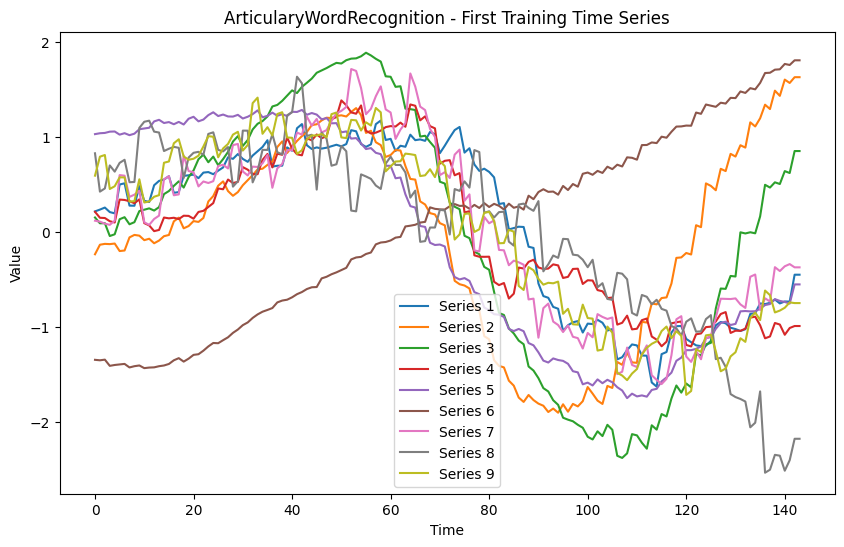

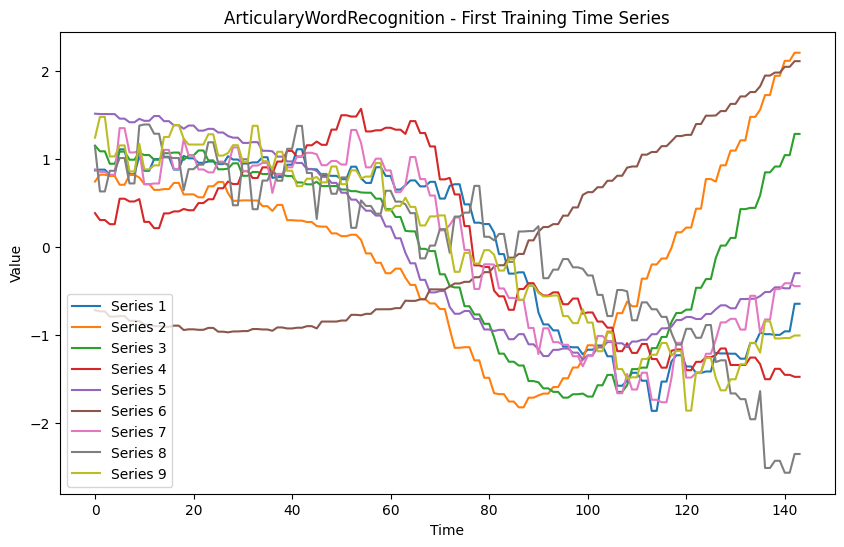

In [20]:
import matplotlib.pyplot as plt

def plot_aeon_dataset(dataset_name: str, TSER_or_MTSC: str = "MTSC", normalize: bool = True, max_T: int = 1000):
    """
    Plots the first time series from the training set of the specified dataset.

    Args:
        dataset_name (str): Name of the dataset
        TSER_or_MTSC (str): Whether to load a TSER or MTSC dataset.
        normalize (bool): Whether to apply z-score normalization based on the train set data.
        max_T (int): Maximum length of the time series. If the time series is longer than this value, it will be average pooled down.
    """
    X_train, y_train, X_test, y_test = get_aeon_dataset(dataset_name, normalize, TSER_or_MTSC, max_T=max_T)
    
    # Plot the first time series in the training set
    plt.figure(figsize=(10, 6))
    for i in range(X_train.shape[2]):
        plt.plot(X_train[0, :, i], label=f'Series {i+1}')
    plt.title(f'{dataset_name} - First Training Time Series')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

# Example usage
plot_aeon_dataset('ArticularyWordRecognition')
plot_aeon_dataset('ArticularyWordRecognition', normalize=False)